# Lab Notebook - Lecture 12

This notebook provides an introduction to evaluating the fairness of your predictive model. This is especially relevant because in modeling human data, treating different socio-demographic groups equitably is especially important. It is also crucial to consider the context of your downstream task and where these predictions will be used.

In this lab, we will investigate **5 different metrics** to measure model fairness:
- equal opportunity
- equalized odds
- disparate impact
- demographic parity
- predictive rate parity

The material for this notebook is inspired by a [Towards Data Science ML fairness tutorial](https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705) by Conor O'Sullivan.

You have already seen three of these metrics in the lecture exploration on flipped classroom data collected at EPFL. In this lab, you will:
- learn about 2 more fairness metrics **(equal opportunity** and **disparate impact)**
- explore a full fairness analysis on a sensitive attribute **Country (Diploma)**
- explore a combined fairness analysis on subgroups involving both **Gender** and **Country (Diploma)**

**Gender** refers to the gender of the student (M for male, F for female, or non-specified), and **Country (Diploma)** represents the country the student completed their diploma from (France, Suisse, or non-specified).

In [1]:
# Load standard imports for the rest of the notebook.
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

DATA_DIR = "./../../data/"

### Load the data

In [3]:
# Load demographic data. The two attributes that are relevant to our analysis are "country_diploma" and "gender",
# although there are many other analyses that can be conducted.

demographics = pd.read_csv(DATA_DIR + 'demographics.csv', index_col=0).reset_index()
demographics

,index,gender,country_diploma,continent_diploma,year_diploma,title_diploma,avg_french_bac,rating_french,scale_french,rating_maths,scale_maths,rating_physics,scale_physics,grade
0,0,M,France,Europe,2018.0,Bacc. étranger,18.28,15.0,20.0,17.0,20.0,19.0,20,2.50
1,1,M,France,Europe,2018.0,Bacc. étranger,17.68,13.0,20.0,18.0,20.0,19.0,20,1.75
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
3,3,M,France,Europe,2018.0,Bacc. étranger,17.78,11.0,20.0,20.0,20.0,19.0,20,4.50
4,4,M,France,Europe,2018.0,Bacc. étranger,18.84,13.0,20.0,19.0,20.0,20.0,20,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,105,M,France,Europe,2018.0,Bacc. étranger,14.76,16.0,20.0,14.0,20.0,15.0,20.0,2.75
210,106,M,Suisse,Europe,2019.0,Mat. reconnue opt. physique et math,NaN,4.5,6.0,6.0,6.0,5.5,6.0,3.25
211,107,M,Suisse,Europe,2018.0,Mat. reconnue opt. physique et math,NaN,5.5,6.0,5.5,6.0,5.5,6.0,5.75
212,108,M,France,Europe,2018.0,Bacc. étranger,17.21,12.0,20.0,17.0,20.0,18.0,20.0,5.50


In [5]:
# We've run a BiLSTM model on the data using a 10-fold cross validation, generating predictions for all 214 students.
predictions = pd.read_csv(DATA_DIR + 'model_predictions.csv')

# Convert predictions between [0, 1] to binary variable for pass / fail {0, 1}
y_pred = [1 if grade < 0.5 else 0 for grade in predictions['grade']]

In [6]:
# Load and process ground truth grades, which are between 0 to 6
# Recieving a score 4 or higher is passing, so we can convert these grades to a binary pass/fail variable {0, 1}
y = [1 if grade >= 4 else 0 for grade in demographics['grade']]

In [7]:
demographics.insert(0, 'y', y)
demographics.insert(1, 'y_pred', y_pred)

#### Enumerate data in each category

Let's examine how many data points are in each category. Often, lack of representation in data subgroups can lead to model bias.

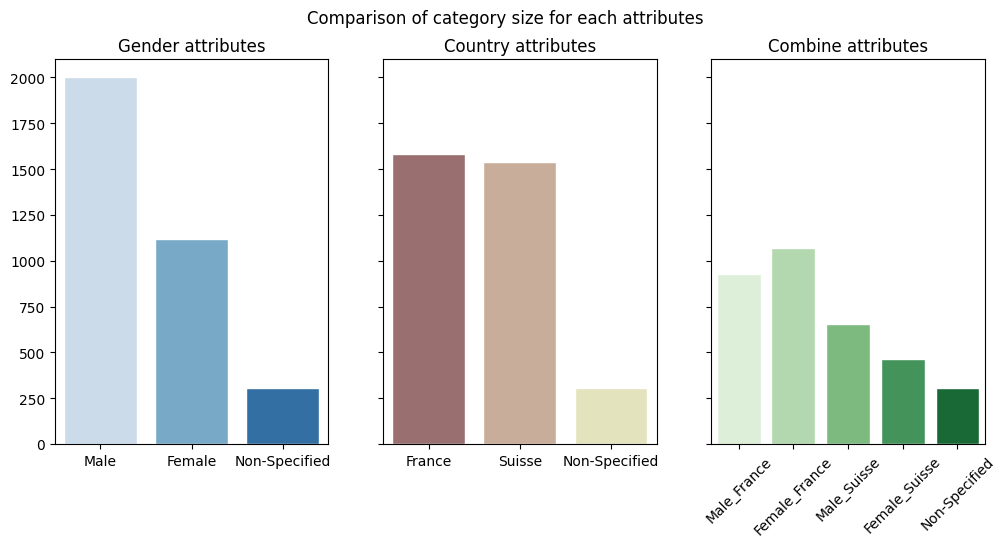

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

M_size = demographics[demographics['gender'] == 'M'].size
F_size = demographics[demographics['gender'] == 'F'].size

France_size = demographics[demographics['country_diploma'] == 'France'].size
Suisse_size = demographics[demographics['country_diploma'] == 'Suisse'].size

France_M_size = demographics[(demographics['country_diploma'] == 'France') & 
                                        (demographics['gender'] == 'M')].size
Suisse_M_size = demographics[(demographics['country_diploma'] == 'Suisse') & 
                                        (demographics['gender'] == 'M')].size
France_F_size = demographics[(demographics['country_diploma'] == 'France') & 
                                        (demographics['gender'] == 'F')].size
Suisse_F_size = demographics[(demographics['country_diploma'] == 'Suisse') & 
                                        (demographics['gender'] == 'F')].size

none_size = demographics[(demographics['country_diploma'].isna())].size

gender_cat = ['Male', 'Female', 'Non-Specified']
sns.barplot(x=gender_cat, y=[M_size, F_size, none_size], palette = 'Blues', edgecolor = 'w', ax=axs[0])
axs[0].set_title("Gender attributes")

country_cat = ['France', 'Suisse', 'Non-Specified']
sns.barplot(x=country_cat, y=[France_size, Suisse_size, none_size], palette = 'pink', edgecolor = 'w', ax=axs[1])
axs[1].set_title("Country attributes")

gender_country_cat = ['Male_France', 'Female_France', 'Male_Suisse', 'Female_Suisse', 'Non-Specified']
sns.barplot(x=gender_country_cat, y=[France_M_size, Suisse_M_size, France_F_size, Suisse_F_size, none_size], palette = 'Greens', edgecolor = 'w', ax=axs[2])
axs[2].set_title("Combine attributes")

fig.suptitle("Comparison of category size for each attributes")
plt.xticks(rotation=45)
plt.show()

## Measuring Fairness

Now, we will move into analyzing methods to measure fairness. Here are the three definitions of fairness we have already seen in lecture, and a function to compute accuracy (which is an imperfect measure of fairness).

In [9]:
def accuracy(df):
    """Calculate accuracy through the confusion matrix."""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # Accuracy
    ACC = (TP + TN) / N 
    
    return ACC

# Equalized odds requires that the true positive rates (TPR) as well as the false positive rates (FPR) are equal across values of the sensitive attribute. 
# That is a similar percentage of the groups should both rightfully and wrongfully benefit.
def equalized_odds(df):
    """Calculate FPR and TPR for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel() 
    
    # True positive rate
    TPR = TP / (TP + FN) 
    
    # False positive rate
    FPR = FP / (FP + TN)
    
    return [TPR, FPR]

# For demographic parity, we compare the difference between the PPPs of the sensitive attributes.
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.
def stats_dp(df, attr, cutoff=0.1):
    PPP_0, PPP_1 = df['PPP'][0], df['PPP'][1]
    ppp_diff = np.round(PPP_1 - PPP_0, 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('|Demographic Parity| > Cutoff?', np.abs(ppp_diff) > cutoff)
    print('------------------------------------')
    print('PPP0 (', df[attr][0], ') =', PPP_0)
    print('PPP1 (', df[attr][1], ') =', PPP_1)
    print('PPP_Diff:', ppp_diff)
    print('Cutoff:', cutoff)

# Predictive value-parity equalizes the probability of a positive outcome, given a positive prediction (PPV) 
# and the probability of a negative outcome given a negative prediction (NPV).

def predictive_value_parity(df):
    """Calculate predictive value parity scores"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Positive Predictive Value
    PPV = TP / (FP + TP) 
    
    # Negative Predictive Value
    NPV = TN / (FN + TN) 
    
    return [PPV, NPV]

In [10]:
gender_df = pd.DataFrame()
gender_df['Gender'] = ['Male', 'Female', 'Non-Specified']
gender_df['ACC'] = [np.round(accuracy(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(accuracy(demographics[demographics['gender'] == 'F']), 3),
                    np.round(accuracy(demographics[demographics['gender'].isna()]), 3)]

gender_df['FPR'] = [np.round(equalized_odds(demographics[demographics['gender'] == 'M'])[1], 3), 
                    np.round(equalized_odds(demographics[demographics['gender'] == 'F'])[1], 3),
                    np.round(equalized_odds(demographics[demographics['gender'].isna()])[1], 3)]

gender_df['PPV'] = [np.round(predictive_value_parity(demographics[demographics['gender'] == 'M'])[0], 3), 
                    np.round(predictive_value_parity(demographics[demographics['gender'] == 'F'])[0], 3),
                    np.round(predictive_value_parity(demographics[demographics['gender'].isna()])[0], 3)]

gender_df['NPV'] = [np.round(predictive_value_parity(demographics[demographics['gender'] == 'M'])[1], 3), 
                    np.round(predictive_value_parity(demographics[demographics['gender'] == 'F'])[1], 3),
                    np.round(predictive_value_parity(demographics[demographics['gender'].isna()])[1], 3)]

In [11]:
gender_df

,Gender,ACC,FPR,PPV,NPV
0,Male,0.728,0.352,0.747,0.700
1,Female,0.729,0.417,0.787,0.609
2,Non-Specified,0.684,1.000,0.867,0.000


### Fairness Definition 4: Equal opportunity

To better capture the benefits of a model we can use the true positive rate (TPR). You can see how we calculate TPR below. The denominator is the number of actual positives. The numerator is the number of correctly predicted positives. In other words, TPR is the percentage of actual positives that were correctly predicted as positive.

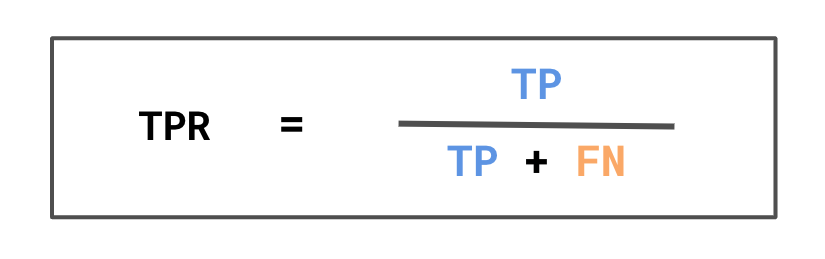

Under **equal opportunity** we consider a model to be fair if the TPRs of the privileged and unprivileged groups are equal. In practice, we will give some leeway for statistic uncertainty. We can require the differences to be less than a certain cutoff (Equation 2). For our analysis, we have taken the ratio. In this case, we require the ratio to be larger than some cutoff (Equation 3). This ensures that the TPR for the unprivileged group is not significantly smaller than for the privileged group.

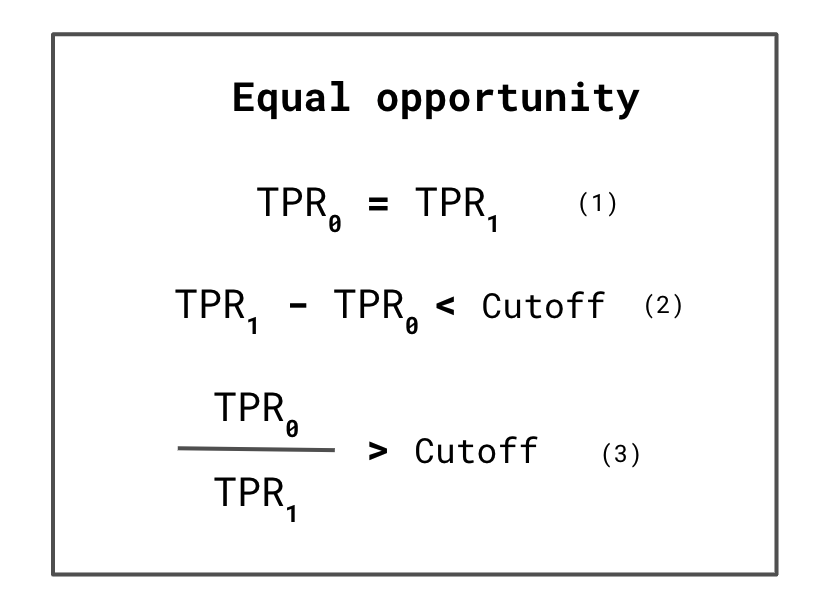

In [12]:
def true_positive_rate(df):
    """Calculate equal opportunity (true positive rate)."""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # True positive rate
    TPR = TP / (TP + FN) 
    
    return TPR 

In [13]:
print("Overall Equal Opportunity:", np.round(true_positive_rate(demographics), 3))

Overall Equal Opportunity: 0.791


#### Sensitive Attribute: Gender

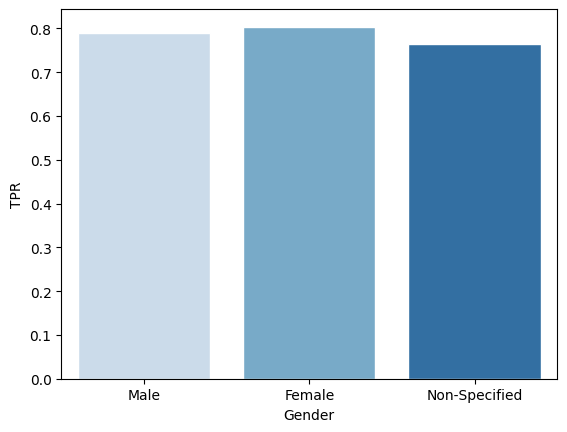

In [14]:
gender_df['TPR'] = [np.round(true_positive_rate(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(true_positive_rate(demographics[demographics['gender'] == 'F']), 3),
                    np.round(true_positive_rate(demographics[demographics['gender'].isna()]), 3)]
       
sns.barplot(x='Gender', y='TPR', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

In [15]:
gender_df

,Gender,ACC,FPR,PPV,NPV,TPR
0,Male,0.728,0.352,0.747,0.700,0.789
1,Female,0.729,0.417,0.787,0.609,0.804
2,Non-Specified,0.684,1.000,0.867,0.000,0.765


In [16]:
# For equal opportunity, we directly compare the difference between TPRs of the sensitive attributes. 
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.

def stats_eq_opp(df, attr, cutoff=0.1):
    TPR_0, TPR_1 = df['TPR'][0], df['TPR'][1]
    equal_opp = np.round(TPR_1 - TPR_0, 3)
    equal_opp_ratio = np.round(TPR_0/TPR_1, 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('|Equal Opportunity| > Cutoff?', np.abs(equal_opp) > cutoff)
    print('------------------------------------')
    print('TPR0 (', df[attr][0], ') =', TPR_0)
    print('TPR1 (', df[attr][1], ') =', TPR_1)
    print('Equal Opportunity:', equal_opp)
    print('Cutoff:', cutoff)


    print('\n------------------------------------')
    print('Equal Opportunity Ratio?', equal_opp_ratio)
    print('------------------------------------')

stats_eq_opp(gender_df, 'Gender')

Sensitive Attr: Gender 

------------------------------------
|Equal Opportunity| > Cutoff? False
------------------------------------
TPR0 ( Male ) = 0.789
TPR1 ( Female ) = 0.804
Equal Opportunity: 0.015
Cutoff: 0.1

------------------------------------
Equal Opportunity Ratio? 0.981
------------------------------------


### False negative rate (FNR)

In some cases, you may want to capture the negative consequences of a model. In FNR, the denominator gives the number of actual positives. Except now we have the number of incorrectly predicted negatives as the numerator. In other words, the FNR is the percentage of actual positives incorrectly predicted as negative.

The FNR can be interpreted as the percentage of people who have wrongfully not benefitted from the model.

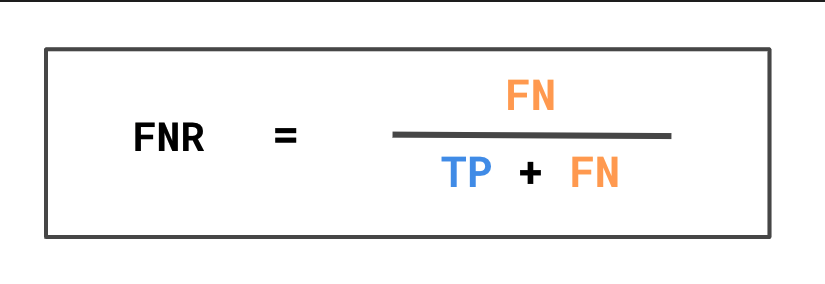

In [17]:
def false_negative_rate(df):
    """Calculate false negative rate"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    # False negative rate
    FNR = FN / (TP + FN) 
  
    return FNR

In [18]:
print("Overall FNR:", np.round(false_negative_rate(demographics), 3))

Overall FNR: 0.209


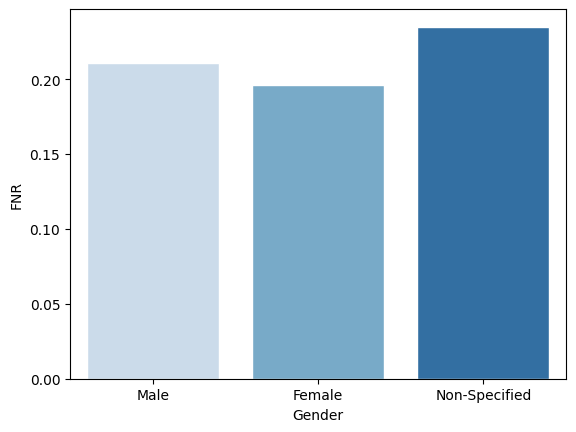

In [19]:
gender_df['FNR'] = [np.round(false_negative_rate(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(false_negative_rate(demographics[demographics['gender'] == 'F']), 3),
                    np.round(false_negative_rate(demographics[demographics['gender'].isna()]), 3)]

       
sns.barplot(x='Gender', y='FNR', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

## Fairness Definition 5: Disparate Impact

Our fifth definition of fairness is disparate impact (DI). We start by calculating the PPP rates seen below. This is the percentage of people who have either been correctly (TP) or incorrectly (FP) predicted as positive. We can interpret this as the percentage of people who will benefit from the model.

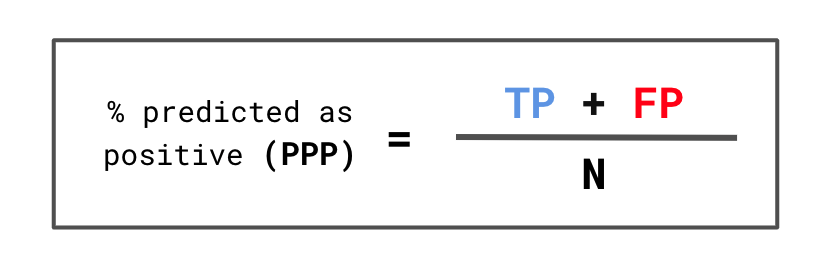

Under DI we consider a model to be fair if we have equal PPP rates. Again, in practice, we use a cutoff to give some leeway. This definition is supposed to represent the legal concept of disparate impact. In the US there is a legal precedent to set the cutoff to 0.8. That is the PPP for the unprivileged group must not be less than 80% of that of the privileged group.

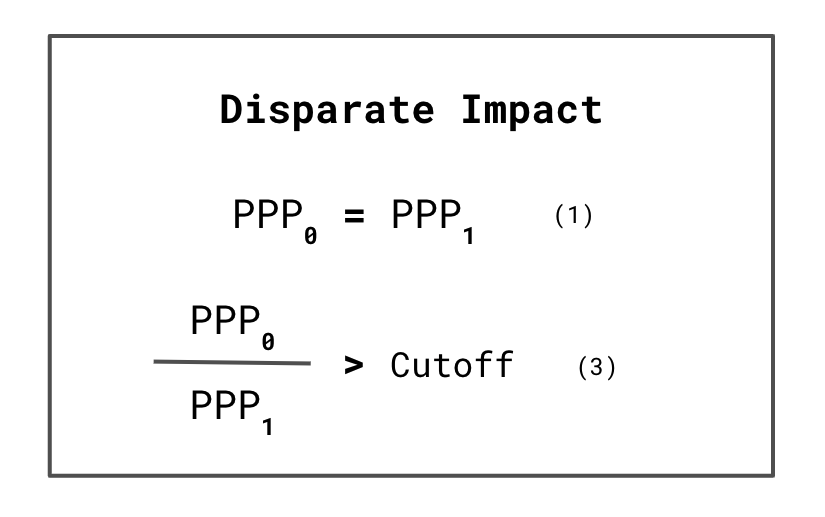

In [20]:
def disparate_impact(df):
    """Calculate PPP for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # predicted as positive
    PPP = (TP + FP) / N 
    
    return PPP

In [21]:
print("Overall PPP:", np.round(disparate_impact(demographics), 3))

Overall PPP: 0.64


#### Sensitive Attribute: Gender

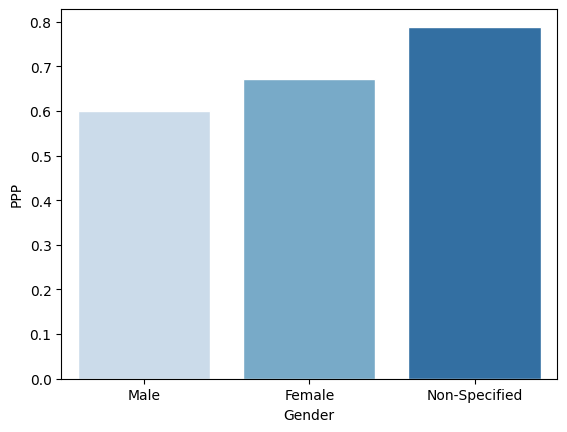

In [22]:
gender_df['PPP'] = [np.round(disparate_impact(demographics[demographics['gender'] == 'M']), 3), 
                    np.round(disparate_impact(demographics[demographics['gender'] == 'F']), 3),
                    np.round(disparate_impact(demographics[demographics['gender'].isna()]), 3)]
       
sns.barplot(x='Gender', y='PPP', data=gender_df, palette = 'Blues', edgecolor = 'w')
plt.show()

In [23]:
# For disparate impact, we compare the ratio between the PPPs of the sensitive attributes.
# We define our significance cutoff at 0.1, stating any difference below 10% can be attributed to random chance.

def stats_ppp(df, attr, cutoff=0.1):
    PPP_0, PPP_1 = df['PPP'][0], df['PPP'][1]
    ppp_ratio = np.round(PPP_0/PPP_1, 3)
    
    print('Sensitive Attr:', attr, '\n')
    
    print('------------------------------------')
    print('Disparate Impact > Cutoff?', np.abs(ppp_ratio) > cutoff)
    print('------------------------------------')
    print('PPP0 (', df[attr][0], ') =', PPP_0)
    print('PPP1 (', df[attr][1], ') =', PPP_1)
    print('PPP_Ratio:', ppp_ratio)
    print('Cutoff:', cutoff)

stats_ppp(gender_df, 'Gender')

Sensitive Attr: Gender 

------------------------------------
Disparate Impact > Cutoff? True
------------------------------------
PPP0 ( Male ) = 0.6
PPP1 ( Female ) = 0.671
PPP_Ratio: 0.894
Cutoff: 0.1


# Your Turn

Compute fairness metrics on the **Country (Diploma)** attribute, which refers to which country a student did their high school diploma in. Fill in the code by referencing the gender analysis above, and write an interpretation of the fairness of your model based on your generated graphs.

In [20]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lab-12',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

Your name:  Test - Vinitra


#### Accuracy

In [27]:
country_df = pd.DataFrame()
country_df['Country (Diploma)'] = ['France', 'Suisse', 'Non-Specified']

country_df['ACC'] = [np.round(accuracy(demographics[demographics['country_diploma'] == 'France']), 3),
                        np.round(accuracy(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                        np.round(accuracy(demographics[demographics['country_diploma'].isna()]), 3)]
country_df


,Country (Diploma),ACC
0,France,0.758
1,Suisse,0.698
2,Non-Specified,0.684


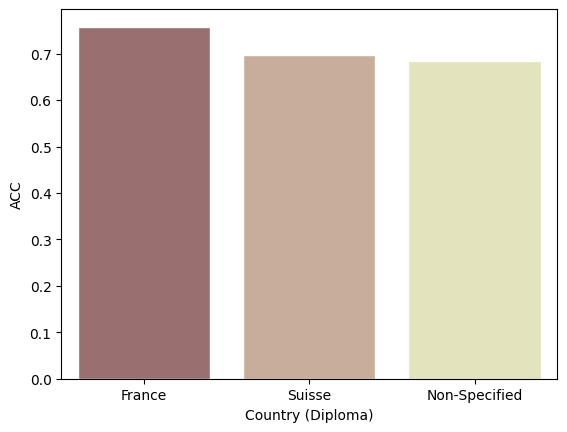

In [28]:
sns.barplot(x='Country (Diploma)', y='ACC', data=country_df, palette = 'pink', edgecolor = 'w')

# send(plt, 1)
plt.show()

#### Equal Opportunity

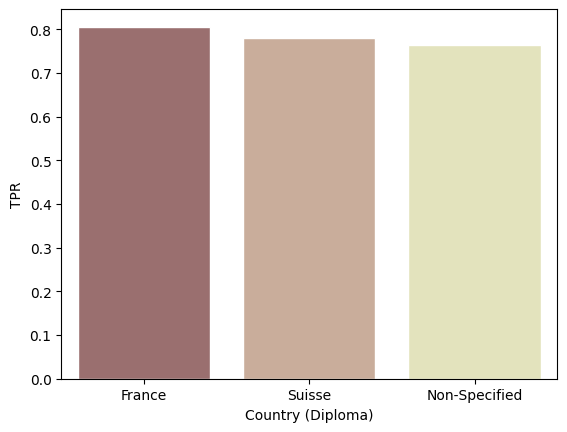

In [29]:
# YOUR TURN: Fill in code here

country_df['TPR'] = [np.round(true_positive_rate(demographics[demographics['country_diploma'] == 'France']), 3),
                        np.round(true_positive_rate(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                        np.round(true_positive_rate(demographics[demographics['country_diploma'].isna()]), 3)]
      
sns.barplot(x='Country (Diploma)', y='TPR', data=country_df, palette = 'pink', edgecolor = 'w')

#send(plt, 2)
plt.show()

In [30]:
stats_eq_opp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
|Equal Opportunity| > Cutoff? False
------------------------------------
TPR0 ( France ) = 0.806
TPR1 ( Suisse ) = 0.78
Equal Opportunity: -0.026
Cutoff: 0.1

------------------------------------
Equal Opportunity Ratio? 1.033
------------------------------------


#### Equalized Odds

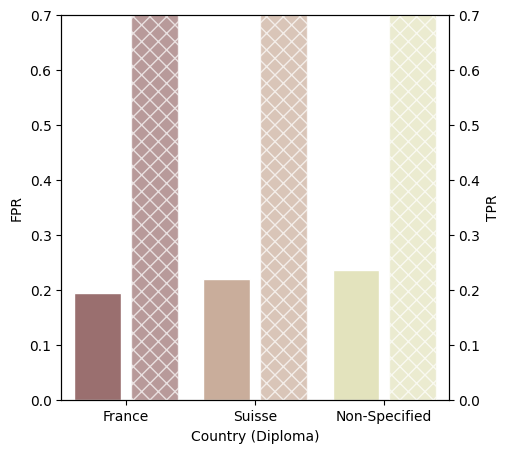

In [32]:
# YOUR TURN: Fill in code here
country_df['FPR'] = [np.round(false_negative_rate(demographics[demographics['country_diploma'] == 'France']), 3),
                        np.round(false_negative_rate(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                        np.round(false_negative_rate(demographics[demographics['country_diploma'].isna()]), 3)]
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Country (Diploma)', y='FPR', data=country_df, palette = 'pink', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Country (Diploma)', y='TPR', data=country_df, palette = 'pink', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

#send(plt, 3)
plt.show()

#### Disparate Impact

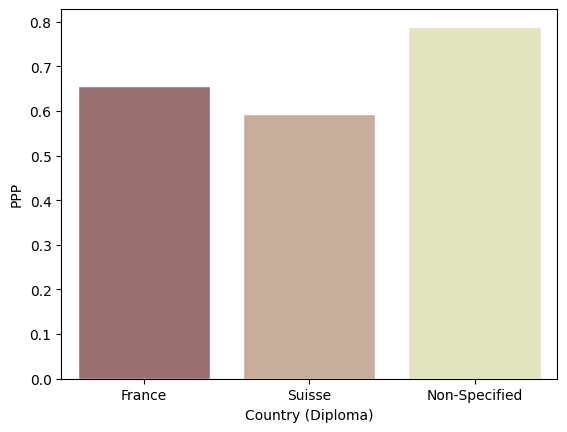

In [33]:
# YOUR TURN: Fill in code here

country_df['PPP'] = [np.round(disparate_impact(demographics[demographics['country_diploma'] == 'France']), 3),
                        np.round(disparate_impact(demographics[demographics['country_diploma'] == 'Suisse']), 3),
                        np.round(disparate_impact(demographics[demographics['country_diploma'].isna()]), 3)]
       
sns.barplot(x='Country (Diploma)', y='PPP', data=country_df, palette = 'pink', edgecolor = 'w')

#send(plt, 4)
plt.show()

In [34]:
stats_ppp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
Disparate Impact > Cutoff? True
------------------------------------
PPP0 ( France ) = 0.657
PPP1 ( Suisse ) = 0.594
PPP_Ratio: 1.106
Cutoff: 0.1


In [35]:
0.657 - 0.594

0.06300000000000006

#### Demographic Parity

In [36]:
stats_dp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
|Demographic Parity| > Cutoff? False
------------------------------------
PPP0 ( France ) = 0.657
PPP1 ( Suisse ) = 0.594
PPP_Diff: -0.063
Cutoff: 0.1


#### Predictive Rate Parity

In [50]:
# below gives a 2d array, where each row is a country and each column is a metric
# unpack the function calls to 
PPV_array, NPV_array = np.array([
    predictive_value_parity(demographics[demographics['country_diploma'] == 'France']),
    predictive_value_parity(demographics[demographics['country_diploma'] == 'Suisse']),
    predictive_value_parity(demographics[demographics['country_diploma'].isna()])
]).T

print('PPV:', PPV_array)
print('NPV:', NPV_array)


PPV: [0.83076923 0.68421053 0.86666667]
NPV: [0.61764706 0.71794872 0.        ]


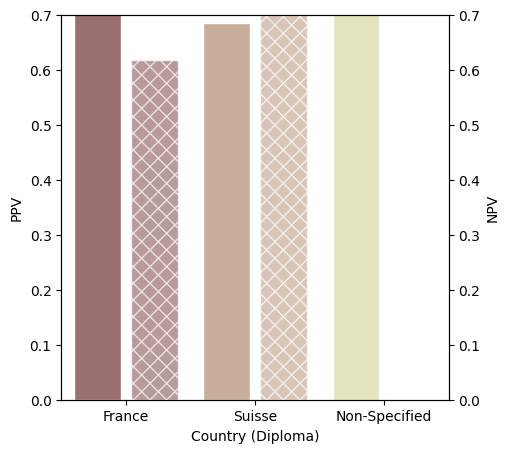

In [52]:
# YOUR TURN: Fill in code here
country_df['PPV'] = PPV_array
country_df['NPV'] = NPV_array
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='Country (Diploma)', y='PPV', data=country_df, palette = 'pink', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='Country (Diploma)', y='NPV', data=country_df, palette = 'pink', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

#send(plt, 5)
plt.show()

In [53]:
country_df

,Country (Diploma),ACC,TPR,FPR,PPP,PPV,NPV
0,France,0.758,0.806,0.194,0.657,0.830769,0.617647
1,Suisse,0.698,0.780,0.220,0.594,0.684211,0.717949
2,Non-Specified,0.684,0.765,0.235,0.789,0.866667,0.000000


In [54]:
stats_dp(country_df, 'Country (Diploma)')

Sensitive Attr: Country (Diploma) 

------------------------------------
|Demographic Parity| > Cutoff? False
------------------------------------
PPP0 ( France ) = 0.657
PPP1 ( Suisse ) = 0.594
PPP_Diff: -0.063
Cutoff: 0.1


In [ ]:
interpretation = """
Predictive value parity is not satisfied for the French and Swiss groups. Because predictive value parity requires 
that the positive predictive value and negative predictive value be equal across groups. Which can be interpreted as
what is the probability of actually being true positive or true negative given that the model predicted positive or negative.

Disparate impact can be thought to be satisfied as the difference of PPP is less than 0.1(our ratio).

Equalized odds requires that the true positive rate and false positive rate be equal across groups. This is not satisfied
"""

send(interpretation, 6)

## Combined Fairness Analysis

It is often not enough to look at one sensitive attribute alone; it is important to identify what unfairness occurs with multiple sensitive attributes together.

In this exploration, you will compute combined fairness metrics on the **gender_country** attribute, which combines sensitive attributes **Gender** and **Country (Diploma)** to have separate metrics for males and females with diplomas from each country. 

Fill in the code by referencing the single variable analysis above, and write an interpretation of the fairness of your model based on your generated plots.

#### Accuracy

In [ ]:
combined_df = pd.DataFrame()
combined_df["gender_country"] = ['Male_France', 'Female_France', 'Male_Suisse', 'Female_Suisse', 'Non-Specified']

# YOUR TURN: Fill in code here

combined_df['ACC'] = ...

sns.barplot(x='gender_country', y='ACC', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation = 10)
plt.show()

#### Equal Opportunity

In [ ]:
# YOUR TURN: Fill in code here
combined_df['TPR'] = ...

sns.barplot(x='gender_country', y='TPR', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation = 10)
plt.show()

In [ ]:
def get_heatmap(df, attr, func, stat='TPR', cutoff=0.1):
    size = df[attr].size
    data = df[stat]
    heatmap = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            heatmap[i, j] = func([data[i], data[j]])
    
    return heatmap

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3))
sns.heatmap(heatmap, ax=ax[0], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[0].set_title("|Equal Opportunity| < cutoff = 0.1 ?")

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.minimum(x[0], x[1]) / np.maximum(x[0], x[1]), 3))
sns.heatmap(heatmap, ax=ax[1], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[1].set_title("Equal Opportunity Ratio > cutoff = 0.1 ?")

plt.show()

#### Equalized Odds

In [ ]:
# YOUR TURN: Fill in code here
combined_df['TPR'] = ...
combined_df['FPR'] = ...


plt.figure(figsize=(5, 5))
ax = sns.barplot(x='gender_country', y='FPR', data=combined_df, palette = 'Greens', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='gender_country', y='TPR', data=combined_df, palette = 'Greens', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

ax.tick_params(labelrotation=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='TPR')
sns.heatmap(heatmap, ax=ax[0], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[0].set_title("|TPR0 - TPR1| ≈ 0 ?")

heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='FPR')
sns.heatmap(heatmap, ax=ax[1], xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
ax[1].set_title("|FPR0 - FPR1| ≈ 0 ?")

plt.show()

#### Disparate Impact

In [ ]:
# YOUR TURN: Fill in code here
combined_df['PPP'] = ...
       
sns.barplot(x='gender_country', y='PPP', data=combined_df, palette = 'Greens', edgecolor = 'w')
plt.xticks(rotation=10)
plt.show()

In [ ]:
heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.minimum(x[0], x[1]) / np.maximum(x[0], x[1]), 3), stat='PPP')
sns.heatmap(heatmap, xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
plt.title("PPP_Ratio > cutoff = 0.1 ?")
plt.show()

#### Demographic Parity

In [ ]:
heatmap = get_heatmap(combined_df, 'gender_country', lambda x: np.round(np.abs(x[0] - x[1]), 3), stat='PPP')
sns.heatmap(heatmap, xticklabels=combined_df['gender_country'], yticklabels=combined_df['gender_country'], annot=True, vmin=0, vmax=1)
plt.title("|Demographic Parity| > cutoff = 0.1 ?")
plt.show()

#### Predictive Rate Parity

In [ ]:
combined_df['PPV'] = ...
combined_df['NPV'] = ...
       
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='gender_country', y='PPV', data=combined_df, palette = 'Greens', edgecolor = 'w')
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.set_ylim([0, 0.7])

ax2 = ax.twinx()
sns.barplot(x='gender_country', y='NPV', data=combined_df, palette = 'Greens', edgecolor = 'w', alpha=0.7, hatch='xx', ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)
ax2.set_ylim([0, 0.7])

ax.tick_params(labelrotation=20)
plt.show()

In [ ]:
# YOUR TURN: Write your interpretation of the fairness analysis here. 
# What has changed from the single variable analysis?

interpretation = """
Your discussion here
"""

send(interpretation, 7)